In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import TomekLinks, ClusterCentroids
from tensorflow.keras.utils import to_categorical
from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import silhouette_score
from collections import Counter
import warnings
import os
import pickle
warnings.filterwarnings('ignore')

class WEBIDS23PreprocessorEnhanced:
    """
    Lớp xử lý dữ liệu WEB-IDS23 cải tiến với batch processing
    và sửa lỗi SMOTE trong smote_undersampling_balance
    """
    
    def __init__(self, chunk_size=500000):
        self.label_encoder = LabelEncoder()
        self.scaler = MinMaxScaler()
        self.onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.feature_columns = []
        self.label_mapping = {}
        self.chunk_size = chunk_size
        self.class_names = [
            'benign', 'bruteforce_http', 'bruteforce_https', 'dos_http', 'dos_https',
            'ftp_login', 'ftp_version', 'hostsweep_Pn', 'hostsweep_sn', 'portscan',
            'revshell_http', 'revshell_https', 'smtp_enum', 'smtp_version',
            'sql_injection_http', 'sql_injection_https', 'ssh_login', 'ssh_login_successful',
            'ssrf_http', 'ssrf_https', 'xss_http', 'xss_https'
        ]
        self.coarse_label_mapping = {
            'benign': 'benign',
            'bruteforce_http': 'bruteforce',
            'bruteforce_https': 'bruteforce',
            'dos_http': 'dos',
            'dos_https': 'dos',
            'ftp_login': 'ftp',
            'ftp_version': 'ftp',
            'hostsweep_Pn': 'reconnaissance',
            'hostsweep_sn': 'reconnaissance',
            'portscan': 'reconnaissance',
            'revshell_http': 'reverse_shell',
            'revshell_https': 'reverse_shell',
            'smtp_enum': 'smtp',
            'smtp_version': 'smtp',
            'sql_injection_http': 'sql_injection',
            'sql_injection_https': 'sql_injection',
            'ssh_login': 'ssh',
            'ssh_login_successful': 'ssh',
            'ssrf_http': 'ssrf',
            'ssrf_https': 'ssrf',
            'xss_http': 'xss',
            'xss_https': 'xss'
        }

    def group_attack_types(self, df, col='attack_type'):
        """Ánh xạ nhãn gốc sang nhãn nhóm"""
        print(f"\n=== GROUP ATTACK TYPES ===")
        if col not in df.columns:
            raise ValueError(f"Cột {col} không tồn tại trong DataFrame")
        df['attack_type_coarse'] = df[col].map(self.coarse_label_mapping)
        df['attack_type_coarse'] = df['attack_type_coarse'].fillna('other')
        df = df.drop(columns=[col])
        print(f"Đã tạo cột 'attack_type_coarse'. Các giá trị: {df['attack_type_coarse'].unique()}")
        return df

    def load_data(self, file_paths):
        """Tải dữ liệu theo chunk từ các file CSV"""
        print("Đang tải dữ liệu theo chunk...")
        dataframes = []
        if isinstance(file_paths, dict):
            for class_name, file_path in file_paths.items():
                try:
                    chunk_iter = pd.read_csv(file_path, chunksize=self.chunk_size)
                    for i, chunk in enumerate(chunk_iter):
                        if 'attack_type' not in chunk.columns:
                            chunk['attack_type'] = class_name
                        dataframes.append(chunk)
                        print(f"Đã tải chunk {i+1} ({len(chunk)} mẫu) từ {class_name}")
                except Exception as e:
                    print(f"Lỗi khi tải file {file_path}: {e}")
        elif isinstance(file_paths, list):
            for file_path in file_paths:
                try:
                    chunk_iter = pd.read_csv(file_path, chunksize=self.chunk_size)
                    for i, chunk in enumerate(chunk_iter):
                        dataframes.append(chunk)
                        print(f"Đã tải chunk {i+1} ({len(chunk)} mẫu) từ {file_path}")
                except Exception as e:
                    print(f"Lỗi khi tải file {file_path}: {e}")
        if dataframes:
            combined_df = pd.concat(dataframes, ignore_index=True)
            print(f"Tổng số mẫu: {len(combined_df)}")
            print(f"Các cột có sẵn: {list(combined_df.columns)}")
            return combined_df
        else:
            raise ValueError("Không thể tải được dữ liệu từ các file đã cho")

    def explore_data(self, df):
        """Khám phá và phân tích dữ liệu"""
        print("\n=== THÔNG TIN TỔNG QUAN ===")
        print(f"Kích thước dữ liệu: {df.shape}")
        print(f"Số features: {df.shape[1]}")
        df.info()
        print("\n=== PHÂN PHỐI NHÃN ===")
        if 'attack_type' in df.columns:
            label_counts = df['attack_type'].value_counts()
            print(label_counts)
            attack_count = (df['attack_type'] != 'benign').sum()
            benign_count = (df['attack_type'] == 'benign').sum()
            print(f"\nTỷ lệ attack: {attack_count/len(df)*100:.2f}%")
            print(f"Tỷ lệ benign: {benign_count/len(df)*100:.2f}%")
        
        print("\n=== THÔNG TIN MISSING VALUES ===")
        missing_info = df.isnull().sum()
        missing_percent = (missing_info / len(df)) * 100
        missing_df = pd.DataFrame({
            'Missing Count': missing_info,
            'Missing Percentage': missing_percent
        })
        print(missing_df[missing_df['Missing Count'] > 0])
        
        print("\n=== THÔNG TIN KIỂU DỮ LIỆU ===")
        print(df.dtypes.value_counts())
        df.describe(include='all')
        print("\n=== THỐNG KÊ SỐ LIỆU ===")
        
        return df.describe()

    def clean_data(self, df):
        """Làm sạch dữ liệu với median imputation và xử lý trùng lặp có chọn lọc"""
        print("\n=== LÀM SẠCH DỮ LIỆU ===")
        initial_shape = df.shape
        
        # Loại bỏ các cột không cần thiết
        columns_to_drop = ['uid', 'ts', 'id.orig_h', 'id.resp_h', 'attack']
        columns_to_drop = [col for col in columns_to_drop if col in df.columns]
        if columns_to_drop:
            df = df.drop(columns=columns_to_drop)
            print(f"Đã loại bỏ các cột: {columns_to_drop}")
        
        # Median imputation cho cột số, mode imputation cho cột phân loại
        missing_cols = df.columns[df.isnull().any()].tolist()
        if missing_cols:
            print(f"Xử lý missing values cho: {missing_cols}")
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if numeric_cols.any():
                for col in numeric_cols.intersection(missing_cols):
                    df[col] = df[col].fillna(df[col].median())
            for col in missing_cols:
                if col not in numeric_cols:
                    df[col] = df[col].fillna(df[col].mode()[0])
        
        # Loại bỏ duplicate dựa trên các cột đặc trưng chính, giữ lại một số mẫu
        duplicates = df.duplicated(subset=[col for col in df.columns if col not in ['attack_type', 'attack']]).sum()
        if duplicates > 0:
            df = df.drop_duplicates(subset=[col for col in df.columns if col not in ['attack_type', 'attack']], keep='first')
            print(f"Đã loại bỏ {duplicates} dòng trùng lặp dựa trên các cột đặc trưng")
        
        # Xử lý infinite values
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
        
        print(f"Kích thước sau khi làm sạch: {df.shape} (từ {initial_shape})")
        return df

    def feature_engineering(self, df):
        
        # Đặc trưng thời gian
        if 'total_pkts' in df.columns and 'flow_duration' in df.columns:
            df['packets_per_second'] = df['total_pkts'] / (df['flow_duration'] + 1)
        else:
            print("Cảnh báo: Thiếu cột 'total_pkts' hoặc 'flow_duration'. Bỏ qua đặc trưng packets_per_second.")
        
        # TCP flags
        flag_cols = [c for c in df.columns if 'flag_count' in c]
        for c in flag_cols:
            df[f'{c}_bin'] = (df[c] > 0).astype(int)
            if 'total_pkts' in df.columns:
                df[f'{c}_ratio'] = df[c] / (df['total_pkts'] + 1)
        
        # OneHotEncoder cho các cột phân loại
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
        for col in ['attack', 'attack_type', 'attack_type_coarse']:
            if col in categorical_cols:
                categorical_cols.remove(col)
        if categorical_cols:
            print(f"OneHot encoding cho: {categorical_cols}")
            encoded_data = self.onehot_encoder.fit_transform(df[categorical_cols])
            encoded_cols = self.onehot_encoder.get_feature_names_out(categorical_cols)
            encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df.index)
            df = df.drop(columns=categorical_cols)
            df = pd.concat([df, encoded_df], axis=1)
        
        print(f"Tổng số features sau engineering: {df.shape[1]}")
        return df
    
    def prepare_features_labels(self, df, target_col='attack_type_coarse'):
        """Chuẩn bị features và labels"""
        print("\n=== CHUẨN BỊ FEATURES VÀ LABELS ===")
        if target_col not in df.columns:
            raise ValueError(f"Cột target {target_col} không tồn tại trong DataFrame. Các cột có sẵn: {list(df.columns)}")
        X = df.drop(columns=[target_col, 'attack'], errors='ignore')
        y = df[target_col]
        self.feature_columns = X.columns.tolist()
        print(f"Số features: {len(self.feature_columns)}")
        y_encoded = self.label_encoder.fit_transform(y)
        self.label_mapping = dict(zip(self.label_encoder.classes_, 
                                    self.label_encoder.transform(self.label_encoder.classes_)))
        print(f"Label mapping: {self.label_mapping}")
        y_categorical = to_categorical(y_encoded)
        print(f"Shape của X: {X.shape}")
        print(f"Shape của y: {y_categorical.shape}")
        print(f"Số classes: {y_categorical.shape[1]}")
        return X, y_categorical, y_encoded

    def balance_data_random_smote(self, X, y, target_samples_dict, k_neighbors=5):
        """
        Cân bằng dữ liệu với RandomUnderSampler cho lớp lớn và SMOTE cho lớp nhỏ.
        
        Parameters:
        -----------
        X : array-like, shape (n_samples, n_features)
            Dữ liệu đầu vào
        y : array-like, shape (n_samples,) hoặc one-hot encoded
            Nhãn của dữ liệu
        target_samples_dict : dict
            Số mẫu mục tiêu cho từng lớp, ví dụ {'benign': 200000, 'bruteforce': 200000, ...}
        k_neighbors : int, optional (default=5)
            Số láng giềng cho SMOTE
        
        Returns:
        --------
        X_balanced : array, shape (n_samples_balanced, n_features)
            Dữ liệu đã cân bằng
        y_balanced_onehot : array, shape (n_samples_balanced, n_classes)
            Nhãn one-hot encoded sau khi cân bằng
        """
        print(f"\n=== RANDOM UNDERSAMPLING + SMOTE ===")
        print(f"Target samples per class: {target_samples_dict}")

        # Chuẩn bị dữ liệu
        X_array = X.values if hasattr(X, 'values') else X
        y_labels = y.argmax(axis=1) if y.ndim > 1 else y
        n_samples = X_array.shape[0]

        # Chuẩn hóa dữ liệu
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X_array)

        # Đếm phân phối lớp ban đầu
        class_counts = Counter(y_labels)
        print("Phân phối trước xử lý:")
        for class_idx, count in sorted(class_counts.items()):
            class_name = self.label_encoder.inverse_transform([class_idx])[0]
            print(f"  {class_name}: {count:,}")

        X_balanced = []
        y_balanced = []

        for class_idx in sorted(class_counts.keys()):
            class_name = self.label_encoder.inverse_transform([class_idx])[0]
            effective_target = target_samples_dict.get(class_name, 0)
            class_indices = np.where(y_labels == class_idx)[0]
            current_count = len(class_indices)

            if effective_target == 0:
                continue

            if current_count > effective_target:
                # RandomUnderSampler cho lớp lớn
                rus = RandomUnderSampler(sampling_strategy={class_idx: effective_target}, 
                                    random_state=42)
                X_resampled, y_resampled = rus.fit_resample(X_scaled, y_labels)
                selected_indices = np.where(y_resampled == class_idx)[0]
                X_balanced.append(X_resampled[selected_indices])
                y_balanced.extend([class_idx] * effective_target)
            else:
                # SMOTE cho lớp nhỏ
                smote = SMOTE(sampling_strategy={class_idx: effective_target},
                            k_neighbors=min(k_neighbors, max(1, current_count-1)),
                            random_state=42)
                X_resampled, y_resampled = smote.fit_resample(X_scaled, y_labels)
                selected_indices = np.where(y_resampled == class_idx)[0]
                X_balanced.append(X_resampled[selected_indices])
                y_balanced.extend([class_idx] * effective_target)

            print(f"  {class_name}: {current_count:,} → {effective_target:,}")

        # Gộp dữ liệu
        X_balanced = np.vstack(X_balanced)
        y_balanced = np.array(y_balanced)

        # Khôi phục về không gian gốc
        X_balanced = scaler.inverse_transform(X_balanced)
        X_balanced = np.clip(X_balanced, a_min=0, a_max=None)

        # Chuyển đổi nhãn sang one-hot encoding
        y_balanced_onehot = to_categorical(y_balanced, num_classes=len(self.label_mapping))

        # In kết quả cuối cùng
        final_counts = Counter(y_balanced)
        print(f"\n=== KẾT QUẢ CUỐI CÙNG ===")
        print(f"Dataset size: {n_samples:,} → {len(X_balanced):,}")
        print("\nPhân phối cuối cùng:")
        total_samples = len(X_balanced)
        for class_idx, count in sorted(final_counts.items()):
            class_name = self.label_encoder.inverse_transform([class_idx])[0]
            percentage = (count / total_samples) * 100
            print(f"  {class_name}: {count:,} ({percentage:.1f}%)")

        # Đánh giá mức độ cân bằng
        counts_array = np.array(list(final_counts.values()))
        balance_ratio = counts_array.min() / counts_array.max()
        print(f"\nBalance ratio (min/max): {balance_ratio:.3f}")
        if balance_ratio > 0.9:
            print("Dataset rất cân bằng")
        elif balance_ratio > 0.8:
            print("Dataset khá cân bằng")
        else:
            print("Dataset chưa hoàn toàn cân bằng")

        return X_balanced, y_balanced_onehot
    def scale_features(self, X_train, X_val, X_test):
        """
        Chuẩn hóa các tập dữ liệu train, val, test sử dụng MinMaxScaler.
        
        Parameters:
        -----------
        X_train : array-like, shape (n_samples_train, n_features)
            Dữ liệu train
        X_val : array-like, shape (n_samples_val, n_features)
            Dữ liệu validation
        X_test : array-like, shape (n_samples_test, n_features)
            Dữ liệu test
        
        Returns:
        --------
        X_train_scaled : array, shape (n_samples_train, n_features)
            Dữ liệu train đã chuẩn hóa
        X_val_scaled : array, shape (n_samples_val, n_features)
            Dữ liệu validation đã chuẩn hóa
        X_test_scaled : array, shape (n_samples_test, n_features)
            Dữ liệu test đã chuẩn hóa
        """
        print("\n=== CHUẨN HÓA DỮ LIỆU ===")
        
        # Chuyển đổi sang numpy array nếu là DataFrame
        X_train_array = X_train.values if hasattr(X_train, 'values') else X_train
        X_val_array = X_val.values if hasattr(X_val, 'values') else X_val
        X_test_array = X_test.values if hasattr(X_test, 'values') else X_test
        
        # Fit scaler trên tập train và transform trên cả 3 tập
        self.scaler.fit(X_train_array)
        X_train_scaled = self.scaler.transform(X_train_array)
        X_val_scaled = self.scaler.transform(X_val_array)
        X_test_scaled = self.scaler.transform(X_test_array)
        
        print(f"Đã chuẩn hóa dữ liệu:")
        print(f"  Train: {X_train_scaled.shape}")
        print(f"  Validation: {X_val_scaled.shape}")
        print(f"  Test: {X_test_scaled.shape}")
        
        return X_train_scaled, X_val_scaled, X_test_scaled
    def split_data(self, X, y, test_size=0.15, val_size=0.15, random_state=42):
        """Chia dữ liệu thành train/val/test"""
        print("\n=== CHIA DỮ LIỆU ===")
        X, y = shuffle(X, y, random_state=random_state)
        try:
            X_train, X_temp, y_train, y_temp = train_test_split(
                X, y, test_size=test_size + val_size, 
                random_state=random_state, stratify=y.argmax(axis=1)
            )
            relative_val_size = val_size / (test_size + val_size)
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=1-relative_val_size,
                random_state=random_state, stratify=y_temp.argmax(axis=1)
            )
        except ValueError as e:
            print(f"Lỗi stratified split: {e}")
            print("Chuyển sang random split...")
            X_train, X_temp, y_train, y_temp = train_test_split(
                X, y, test_size=test_size + val_size, random_state=random_state
            )
            relative_val_size = val_size / (test_size + val_size)
            X_val, X_test, y_val, y_test = train_test_split(
                X_temp, y_temp, test_size=1-relative_val_size, random_state=random_state
            )
        
        print(f"Training set: {X_train.shape}")
        print(f"Validation set: {X_val.shape}")
        print(f"Test set: {X_test.shape}")
        print("\nPhân bố nhãn trong các tập:")
        print("Train:", Counter(y_train.argmax(axis=1)))
        print("Validation:", Counter(y_val.argmax(axis=1)))
        print("Test:", Counter(y_test.argmax(axis=1)))
        
        return X_train, X_val, X_test, y_train, y_val, y_test

    def save_processed_data(self, X_train, X_val, X_test, y_train, y_val, y_test, 
                           save_dir='processed_data'):
        """Lưu dữ liệu đã xử lý"""
        os.makedirs(save_dir, exist_ok=True)
        np.save(f'{save_dir}/X_train.npy', X_train)
        np.save(f'{save_dir}/X_val.npy', X_val)
        np.save(f'{save_dir}/X_test.npy', X_test)
        np.save(f'{save_dir}/y_train.npy', y_train)
        np.save(f'{save_dir}/y_val.npy', y_val)
        np.save(f'{save_dir}/y_test.npy', y_test)
        metadata = {
            'feature_columns': self.feature_columns,
            'label_mapping': self.label_mapping,
            'num_classes': len(self.label_mapping),
            'num_features': len(self.feature_columns)
        }
        with open(f'{save_dir}/metadata.pkl', 'wb') as f:
            pickle.dump(metadata, f)
        with open(f'{save_dir}/scaler.pkl', 'wb') as f:
            pickle.dump(self.scaler, f)
        with open(f'{save_dir}/onehot_encoder.pkl', 'wb') as f:
            pickle.dump(self.onehot_encoder, f)
        print(f"\nĐã lưu dữ liệu xử lý vào thư mục: {save_dir}")

    def full_preprocessing_pipeline(self, file_paths, use_smote_undersampling=True,
                                  target_samples_dict=None, k_neighbors=5,
                                  save_data=True, save_dir='processed_data'):
        """Pipeline xử lý dữ liệu hoàn chỉnh với batch processing"""
        print("=== BẮT ĐẦU PIPELINE XỬ LÝ DỮ LIỆU ===")
        try:
            df = self.load_data(file_paths)
            self.explore_data(df)
            df = self.clean_data(df)
            df = self.feature_engineering(df)
            df = self.group_attack_types(df, col='attack_type')
            X, y, y_encoded = self.prepare_features_labels(df, target_col='attack_type_coarse')
            X_train, X_val, X_test, y_train, y_val, y_test = self.split_data(X, y)
            if use_smote_undersampling:
                X_train, y_train = self.balance_data_random_smote(X_train, y_train, target_samples_dict, k_neighbors)
            X_train_scaled, X_val_scaled, X_test_scaled = self.scale_features(X_train, X_val, X_test)
            df.head(15)
            if save_data:
                self.save_processed_data(
                    X_train_scaled, X_val_scaled, X_test_scaled,
                    y_train, y_val, y_test, save_dir
                )
            print("\n=== HOÀN THÀNH PIPELINE XỬ LÝ DỮ LIỆU ===")
            return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test
        except Exception as e:
            print(f"\nLỗi trong pipeline: {e}")
            print("\nGợi ý khắc phục:")
            print("1. Kiểm tra đường dẫn file có đúng không")
            print("2. Thử tăng chunk_size (ví dụ: 1000000)")
            print("3. Thử giảm target_samples_per_class xuống (ví dụ: 1000)")
            print("4. Đặt use_smote_undersampling=False để không balance")
            print("5. Kiểm tra các cột trong dữ liệu bằng log từ load_data và feature_engineering")
            raise

if __name__ == "__main__":
    preprocessor = WEBIDS23PreprocessorEnhanced(chunk_size=500000)
    file_paths = {
        'benign': r"D:\Download\dataverse_files\web-ids23\web-ids23_benign.csv",
        'bruteforce_http': r"D:\Download\dataverse_files\web-ids23\web-ids23_bruteforce_http.csv",
        'bruteforce_https': r"D:\Download\dataverse_files\web-ids23\web-ids23_bruteforce_https.csv",
        'dos_http': r"D:\Download\dataverse_files\web-ids23\web-ids23_dos_http.csv",
        'dos_https': r"D:\Download\dataverse_files\web-ids23\web-ids23_dos_https.csv",
        'ftp_login': r"D:\Download\dataverse_files\web-ids23\web-ids23_ftp_login.csv",
        'ftp_version': r"D:\Download\dataverse_files\web-ids23\web-ids23_ftp_version.csv",
        'hostsweep_Pn': r"D:\Download\dataverse_files\web-ids23\web-ids23_hostsweep_Pn.csv",
        'hostsweep_sn': r"D:\Download\dataverse_files\web-ids23\web-ids23_hostsweep_sn.csv",
        'portscan': r"D:\Download\dataverse_files\web-ids23\web-ids23_portscan.csv",
        'revshell_http': r"D:\Download\dataverse_files\web-ids23\web-ids23_revshell_http.csv",
        'revshell_https': r"D:\Download\dataverse_files\web-ids23\web-ids23_revshell_https.csv",
        # 'smtp_enum': r"D:\Download\dataverse_files\web-ids23\web-ids23_smtp_enum.csv",
        'smtp_version': r"D:\Download\dataverse_files\web-ids23\web-ids23_smtp_version.csv",
        'sql_injection_http': r"D:\Download\dataverse_files\web-ids23\web-ids23_sql_injection_http.csv",
        'sql_injection_https': r"D:\Download\dataverse_files\web-ids23\web-ids23_sql_injection_https.csv",
        'ssh_login': r"D:\Download\dataverse_files\web-ids23\web-ids23_ssh_login.csv",
        'ssh_login_successful': r"D:\Download\dataverse_files\web-ids23\web-ids23_ssh_login_successful.csv",
        'ssrf_http': r"D:\Download\dataverse_files\web-ids23\web-ids23_ssrf_http.csv",
        'ssrf_https': r"D:\Download\dataverse_files\web-ids23\web-ids23_ssrf_https.csv",
        'xss_http': r"D:\Download\dataverse_files\web-ids23\web-ids23_xss_http.csv",
        'xss_https': r"D:\Download\dataverse_files\web-ids23\web-ids23_xss_https.csv",
    }
    target_samples_dict = {
        'benign': 150000,
        'bruteforce': 150000,
        'dos': 80000,
        'ftp': 70000,
        'reconnaissance': 50000,
        'reverse_shell': 50000,
        'smtp': 50000,
        'sql_injection': 80000,
        'ssh': 50000,
        'ssrf': 50000,
        'xss': 50000
    }
    try:
        X_train, X_val, X_test, y_train, y_val, y_test = preprocessor.full_preprocessing_pipeline(
            file_paths=file_paths,
            use_smote_undersampling=True,
            target_samples_dict=target_samples_dict,
            k_neighbors=5,
            save_data=True,
            save_dir='webids23_processed_final'
        )
        print(f"\nDữ liệu đã sẵn sàng cho training:")
        print(f"Training: {X_train.shape} features, {y_train.shape} labels")
        print(f"Validation: {X_val.shape} features, {y_val.shape} labels")
        print(f"Test: {X_test.shape} features, {y_test.shape} labels")
    except Exception as e:
        print(f"Lỗi trong quá trình xử lý: {e}")
        print("Vui lòng kiểm tra đường dẫn file và định dạng dữ liệu.")

=== BẮT ĐẦU PIPELINE XỬ LÝ DỮ LIỆU ===
Đang tải dữ liệu theo chunk...
Đã tải chunk 1 (500000 mẫu) từ benign
Đã tải chunk 2 (325187 mẫu) từ benign
Đã tải chunk 1 (500000 mẫu) từ bruteforce_http
Đã tải chunk 2 (412503 mẫu) từ bruteforce_http
Đã tải chunk 1 (500000 mẫu) từ bruteforce_https
Đã tải chunk 2 (365126 mẫu) từ bruteforce_https
Đã tải chunk 1 (86443 mẫu) từ dos_http
Đã tải chunk 1 (33216 mẫu) từ dos_https
Đã tải chunk 1 (468275 mẫu) từ ftp_login
Đã tải chunk 1 (11688 mẫu) từ ftp_version
Đã tải chunk 1 (500000 mẫu) từ hostsweep_Pn
Đã tải chunk 2 (500000 mẫu) từ hostsweep_Pn
Đã tải chunk 3 (500000 mẫu) từ hostsweep_Pn
Đã tải chunk 4 (500000 mẫu) từ hostsweep_Pn
Đã tải chunk 5 (500000 mẫu) từ hostsweep_Pn
Đã tải chunk 6 (500000 mẫu) từ hostsweep_Pn
Đã tải chunk 7 (492290 mẫu) từ hostsweep_Pn
Đã tải chunk 1 (22637 mẫu) từ hostsweep_sn
Đã tải chunk 1 (500000 mẫu) từ portscan
Đã tải chunk 2 (500000 mẫu) từ portscan
Đã tải chunk 3 (500000 mẫu) từ portscan
Đã tải chunk 4 (500000 mẫu) từ 

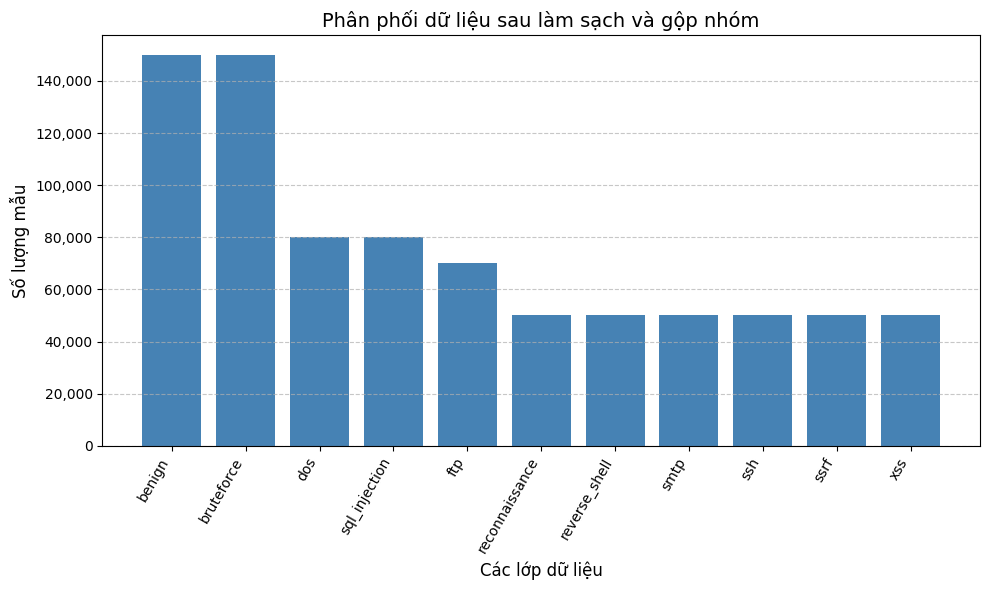

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Dữ liệu sau khi làm sạch và gộp nhóm
data_balanced = {
    "benign": 150000,
    "bruteforce": 150000,
    "dos": 80000,
    "ftp": 70000,
    "reconnaissance": 50000,
    "reverse_shell": 50000,
    "smtp": 50000,
    "sql_injection": 80000,
    "ssh": 50000,
    "ssrf": 50000,
    "xss": 50000,
}


# Sắp xếp dữ liệu giảm dần
sorted_cleaned = dict(sorted(data_balanced.items(), key=lambda x: x[1], reverse=True))

# Vẽ biểu đồ
plt.figure(figsize=(10, 6), facecolor="white")
plt.bar(sorted_cleaned.keys(), sorted_cleaned.values(), color="steelblue")

# Tùy chỉnh biểu đồ
plt.title("Phân phối dữ liệu sau cân bằng", fontsize=14)
plt.xlabel("Các lớp dữ liệu", fontsize=12)
plt.ylabel("Số lượng mẫu", fontsize=12)
plt.xticks(rotation=60, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Hiển thị giá trị tuyệt đối thay vì dạng khoa học
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

plt.tight_layout()
plt.show()
